# Horse Health 🐴

## Domain Expertise

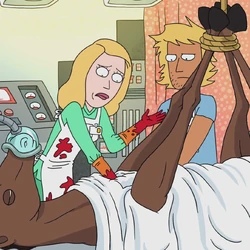

### Surgery
We note that in the original dataset, **1** means "was treated with surgery", and **2** means it "was treated without surgery".

### Age
Young means **less than 6 months old**

### Temp of Extremities
This variable is gathered as "subjective observation"

### Peripheral Pulse
Another "subjective observation"

### Mucous Membrane
A "subjective observation"

### Capillary Refill Time
A "subjective observation". Generally, the higher the refill time, the poorer the circulation. the original dataframe has "other" as a category whereas this one has **exactly 3 seconds**.

### Pain
This is a "subjective observation". Previous measurements may also influence a perceived pain level. This should not be discrete. Generally the higher the perceived pain, the more likely the horse is to need surgery. It is possible this feature could be used to impute missing surgery values and then dropped.

### Peristalsis
A somewhat discrete variable. Likely the "distend small" can be set to mild or hypermotile. It can also be numerized and given a special number as well.

### Abdominal Distention
The original datacard notes this as an **important** parameter. It notes that having severe ```Abdominal Distension``` will be ```Painful``` and likely require ```Surgery```

### Nasogastric Tube
This is referring to any amounts of gas coming out of this tube. A large amount of this is likely to give the horse discomfort.

### Nasogastric Reflux
The greater amount of reflux, the more likelihood that there is some serious obstruction to the fluid passage from the rest of the intestine.

### Recto Exam Feces
Absent feces likely means there is an obstruction.

### Abdomen

* **Firm** feces in the large intestine is probably an obstruction caused by a mechanical impaction and is normally treated medically
* **Distended** small intestine or large intestine usually indicates a surgical lesion 

### Abdomo Appearance

So a needle is stuck into the horses' abdomen and fluid obtained from the horses abdominal cavity with the fluid appearance observed to obtain this variable.
Usually **clear** is normal, with **cloudy** or **serosanguinous** indicating a compromised gut.

### Surgical Lesion

Was the type of lesion caused by surgery? This value is always known.

### 

## Initial Configuration ⚙️

### Import Libraries 📚

In [2]:
# Data Manipulation
import numpy as np
import pandas as pd

# Plotting & EDA
import matplotlib.pyplot as plt

### Global Variables 🌐

In [3]:
target = 'outcome'

### Helper Functions ƛ

In [4]:
"""Helper function to show a simple pie chart of a categorical variable for distribution analysis"""
def do_pie(df, col, title=""):
    if col not in df.columns:
        print("Error, column specified is not in the dataframe's columns")
        return
    val_counts = df[col].value_counts()
    plt.pie(val_counts, labels=val_counts.keys(), autopct='%1.1f%%')
    if title == "":
        title = "Distribution of " + col
    plt.title(title)
    plt.show()

"""Helper function to plot side-by-side pie charts for the different survival rates for differing values in a column
  NOTE: the otherCol needs to be a boolean column with value counts else this function will likely break"""
def plot_target_representation(df, col, otherCol=target):
    grouped = df.groupby([col, otherCol]).size().unstack().fillna(0)
    value_counts = df[col].value_counts()
    target_labels = df[otherCol].value_counts().keys().sort_values()
    fig, axes = plt.subplots(1, len(value_counts.keys()), figsize=(16,6))
    for idx, key in enumerate(value_counts.keys()):
        axes[idx].pie(grouped.loc[key], labels=target_labels, autopct='%1.1f%%', startangle=90)
        axes[idx].set_title(col + " " + str(key))
    plt.tight_layout()
    plt.show()
    
"""Gets the ordinal, categorical and continuous feature types blindly"""
def get_feature_types(df):
    ordinal, categorical, numerical = [], [], []
    for col in df.columns:
        if col == target:
            continue
        # elif len(df[col].value_counts().keys()) == 2:
        #     ordinal.append(col)

        # Columns with 10 or less values, or columns that are objects/strings
        elif len(df[col].value_counts().keys()) <= 10 or df[col].dtype=='O':
            categorical.append(col)
        else:
            numerical.append(col)
    return ordinal, categorical, numerical

## EDA 🔍

### Reading in Data 💿

There are only **1235** data entries while there are **29** features. This may require finding more data.

In [5]:
df = pd.read_csv('./data/train.csv')
df.shape

(1235, 29)

### General EDA

There are a lot of 'object' data types that will need individual analysis for further evaluation. It looks like there are quite a lot of variables with some null values as well.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1235 entries, 0 to 1234
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1235 non-null   int64  
 1   surgery                1235 non-null   object 
 2   age                    1235 non-null   object 
 3   hospital_number        1235 non-null   int64  
 4   rectal_temp            1235 non-null   float64
 5   pulse                  1235 non-null   float64
 6   respiratory_rate       1235 non-null   float64
 7   temp_of_extremities    1196 non-null   object 
 8   peripheral_pulse       1175 non-null   object 
 9   mucous_membrane        1214 non-null   object 
 10  capillary_refill_time  1229 non-null   object 
 11  pain                   1191 non-null   object 
 12  peristalsis            1215 non-null   object 
 13  abdominal_distention   1212 non-null   object 
 14  nasogastric_tube       1155 non-null   object 
 15  naso

* ```id``` appears to be an index of the rows (unlike in the titanic datasets where it was valuable). For training purposes we can feel safe removing it.
* ```hospital_number``` will likely be used as a categorical variable.
* ```Rectal temp``` seems to be normally distributed at first glance.
* ```pulse``` seems to be normally distributed as well.
* The ```respiratory rate``` may have some high-value outliers to consider.
* ```nasogastric reflulx ph``` seems normally distributed.
* ```packed cell volume``` seems normally distributed with a slight skew.
* ```total protein``` seems to follow same patterns as above.
* ```adomo protein``` may have a right skew.
* ```lesion_``` variables seem to exibit severe right skews for the ```2``` and ```3``` with a left skew for ```1```

In [7]:
df.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


Looks like **12** of the variables have missing values. With normal datasets these missing values would be negligable, however given the minimal size of this dataset, this will certainly have some level of impact.

The ```abdomen``` and ```rectal exam feces``` have the most missing values (over **15%** of the sample population).

In [8]:
df.isnull().sum().sort_values(ascending=False)

abdomen                  213
rectal_exam_feces        190
nasogastric_tube          80
peripheral_pulse          60
abdomo_appearance         48
pain                      44
temp_of_extremities       39
abdominal_distention      23
nasogastric_reflux        21
mucous_membrane           21
peristalsis               20
capillary_refill_time      6
lesion_3                   0
lesion_2                   0
lesion_1                   0
surgical_lesion            0
total_protein              0
abdomo_protein             0
cp_data                    0
id                         0
packed_cell_volume         0
nasogastric_reflux_ph      0
surgery                    0
respiratory_rate           0
pulse                      0
rectal_temp                0
hospital_number            0
age                        0
outcome                    0
dtype: int64

There are **no** duplicated values to consider.

In [9]:
df.duplicated().sum()

0

In [10]:
df.columns

Index(['id', 'surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data', 'outcome'],
      dtype='object')

### Target Variable Analysis 🎯

The target variable ```outcome``` is somewhat-evenly distributed between **lived**, **died** and **euthanized**. There is a slight majority of lived and minority of euthanized (though about half the horses lived and half ultimately died).

It is quite likely that the main challenge in machine learning models is going to be picking out which horses died vs were euthanized, though this is just a hypothesis.

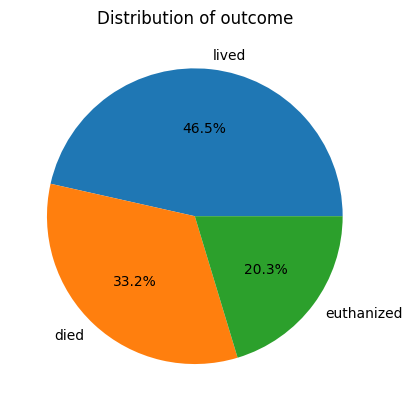

In [11]:
do_pie(df, target)

### Categorical Variable Analysis 📊

In [12]:
df_clean = df.copy()

The below cell drops the ```id``` to keep analysis simple.

In [13]:
if 'id' in df_clean.columns: df_clean = df_clean.drop('id', axis=1)

The datacard explicitly says that ```lesion_3``` has no statistical correlation

In [ ]:
if 'lesion_3' in df_clean.columns: df_clean = df_clean.drop('lesion_3', axis=1)

The below cell splits the dataframe features into numerical and categorical lists based on the number of unique values and the data types.

In [14]:
ordinal, categorical, numerical = get_feature_types(df)
print("There are", len(ordinal), "ordinal variables: ", str(ordinal))
print("There are", len(numerical), "numerical variables: ", str(numerical))
print("There are", len(categorical), "categorical variables: ", str(categorical))

There are 0 ordinal variables:  []
There are 10 numerical variables:  ['id', 'hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1']
There are 18 categorical variables:  ['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'lesion_2', 'lesion_3', 'cp_data']


#### Plotting Categorical Variables

In [15]:
df_clean['lesion_1'].value_counts()

lesion_1
2208     152
3205     116
2205     104
2209     102
0         94
3111      91
2124      52
1400      49
4205      45
2112      40
31110     39
2206      35
5400      35
7111      31
2113      30
2207      26
400       15
7400      14
3209      13
7209      12
4300       9
3025       9
12208      8
2300       8
8300       7
2322       6
3113       6
5206       6
3207       6
8400       5
9400       5
5000       5
3133       4
11300      4
5205       4
5111       4
3115       4
6111       4
1124       3
4124       3
11400      3
2111       3
4206       3
1111       2
6112       2
300        2
3124       2
6209       2
2305       2
5124       2
3112       1
3300       1
2202       1
4207       1
11124      1
21110      1
41110      1
Name: count, dtype: int64

In [22]:
df_clean['lesion_2'].value_counts()

lesion_2
0       1227
1400       4
3111       2
3112       2
Name: count, dtype: int64

In [23]:
df_clean['lesion_3'].value_counts()

lesion_3
0       1233
2209       2
Name: count, dtype: int64

The below cell shows pie charts of the categorical variables. We are able to make a few observations about the variable distributions here:
* ```surgery``` ocurred for a slightly-imbalanced majority of **71.8%** of the horses.
* ```age``` is actually classified as either **adult** or **young** with a moderate imbalance of only **6.1%** being young.
* A moderate imbalance of the ```extremities``` were **cool** while the imbalanced minority of **warm** ```extremities``` only characterizes **4.3%** of the training sample.
* Most ```perirpheral pulses``` were normal, while **2%** were either **increased** or **absent**, characterizing a severe data imbalance.
* Given there are 6 unique categories, the ```mucos membrane``` is quite evenly distributed.
* ```capillary refill time``` has a severely underrepresented **3 second** category. After looking into domain expertise for why this category may be here, one would consider adding it to the majority class as "3 second or less" or something of the idea.
* ```pain``` is nicely-balanced for having several categories with the exception of **slight**, which should likely be added to **mild**. This variable could ALMOST be considered an increasing/continuous variable if **alert** and **depressed** weren't categories. How do horses beocme obviously-depressed? I'd like to see how this dataset was assembled.
* ```peristalsis``` has **3** severely underrepresented categories. Domain expertise will need to be leveraged to understand how to aggregate these variables.
* ```abdominal dystension``` is very well-balanced for a multicategorical feature. Given it is in 'order' from **none** ➡️ **slight** ➡ **moderate** ➡ **severe**, so it could be ordered to reduce dimensionality.
* Likewise to the above can be said about the ```nasogastric tube```.
* The ```nasogastric reflux``` is well-balanced with the exception of the severely-underrepresented **slight** value. It will be worth researching whether it is of high value, or if it can be simply put into "less than 1 liter" category. This variable could also be made numerical, which could be useful.
* The ```recto-exam feces``` has a moderate imbalance of **increased** and a severe imbalance of **serosanguious** (which is usually fluids leaving a wound that is healing)
* ```Distribution of Abdomen``` has some moderate categorical imbalances. Null values could conveniently be added to the **other** category.
* ```Abdomo Appearance``` is relatively nicely-distributed.
* There is a mild imbalance of **75%** of the horses having a ```surgical lesion``` as opposed to not.
* ```lesion_2``` and ```lesion_3``` have some insane imbalances worth looking into to see if these features are of any value in the first place.
* ```cp_data``` is well-balanced

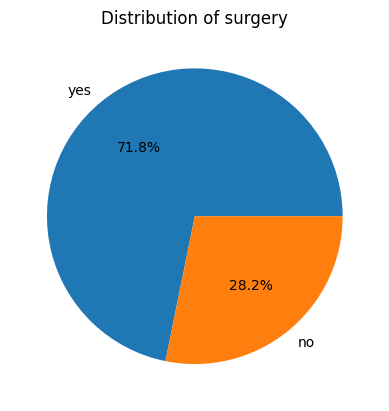

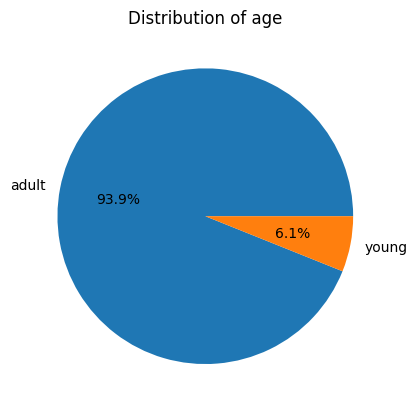

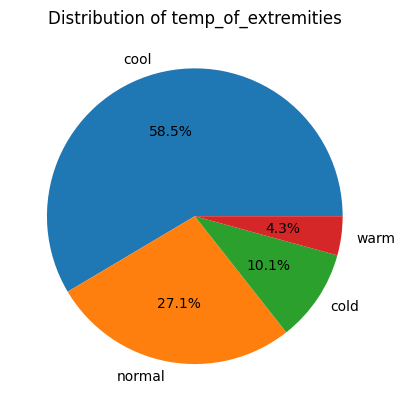

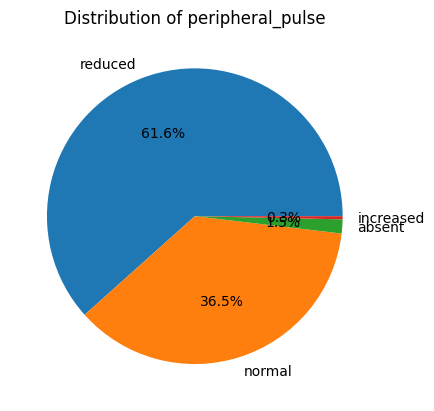

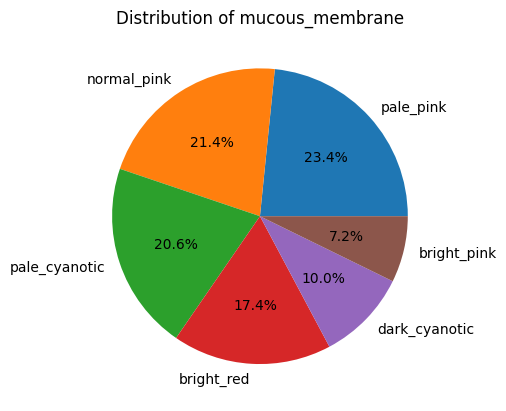

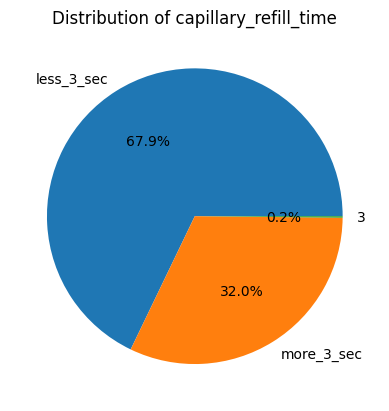

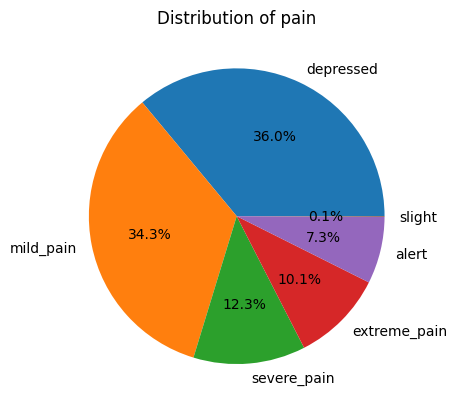

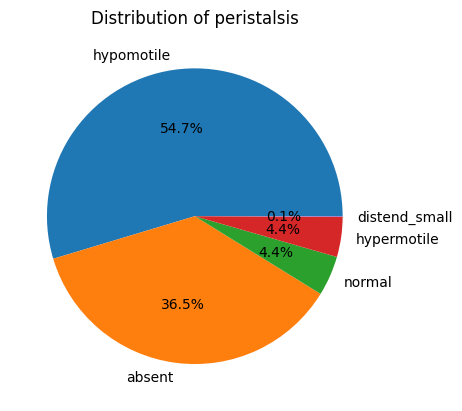

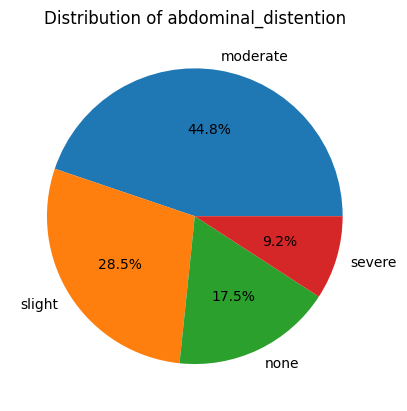

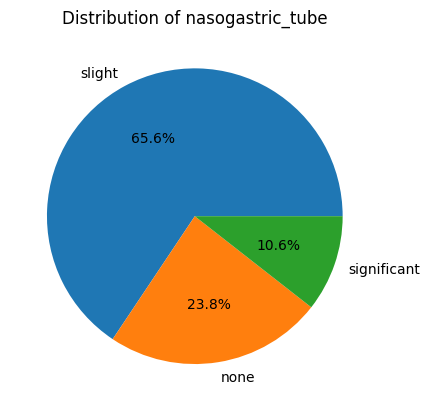

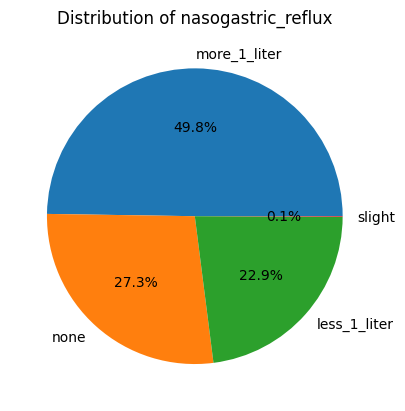

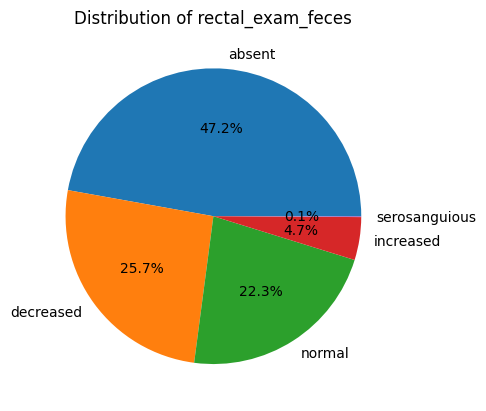

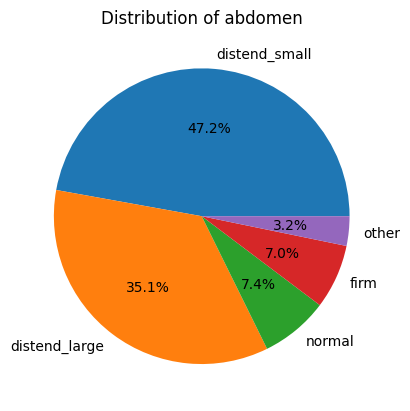

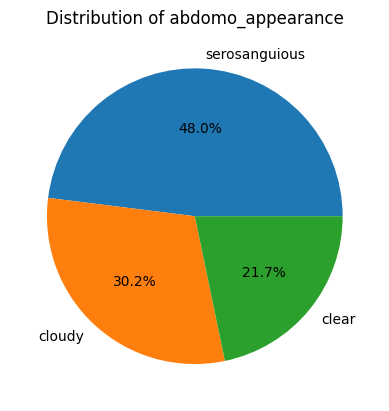

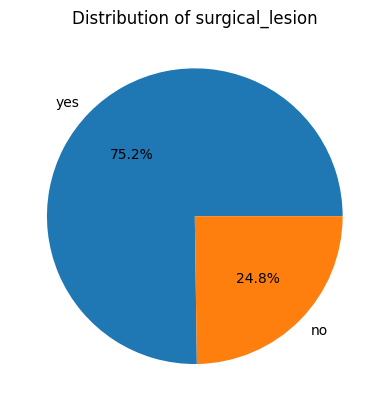

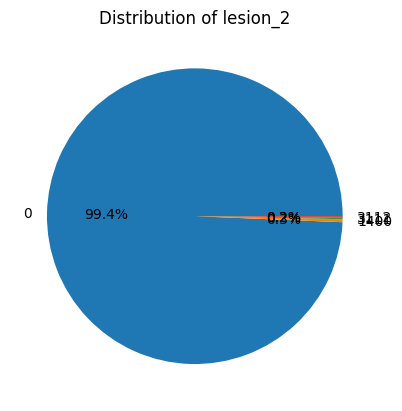

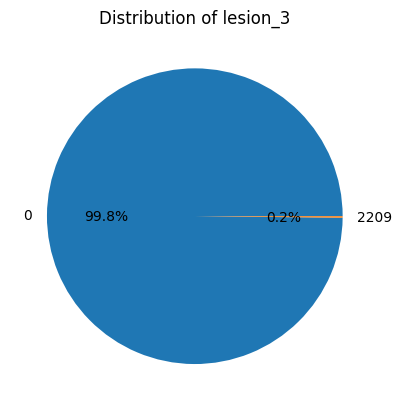

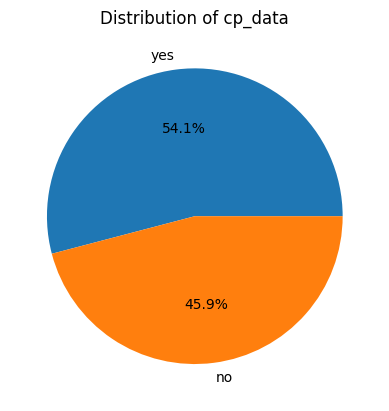

In [16]:
for col in categorical:
    do_pie(df, col)

#### Categorical Variable Target Distribution
By showing the distribution of the target variable between categories, we are able to make some useful observations:
* Strangely looks like a lot more who underwent ```surgery``` died.
* Far more of the **young** horses **died**, and almost none of the **young** horses were **euthanized**

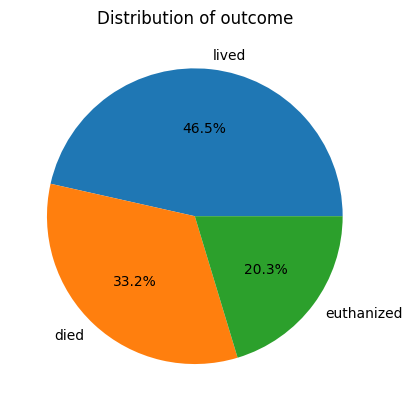

In [17]:
do_pie(df, target)

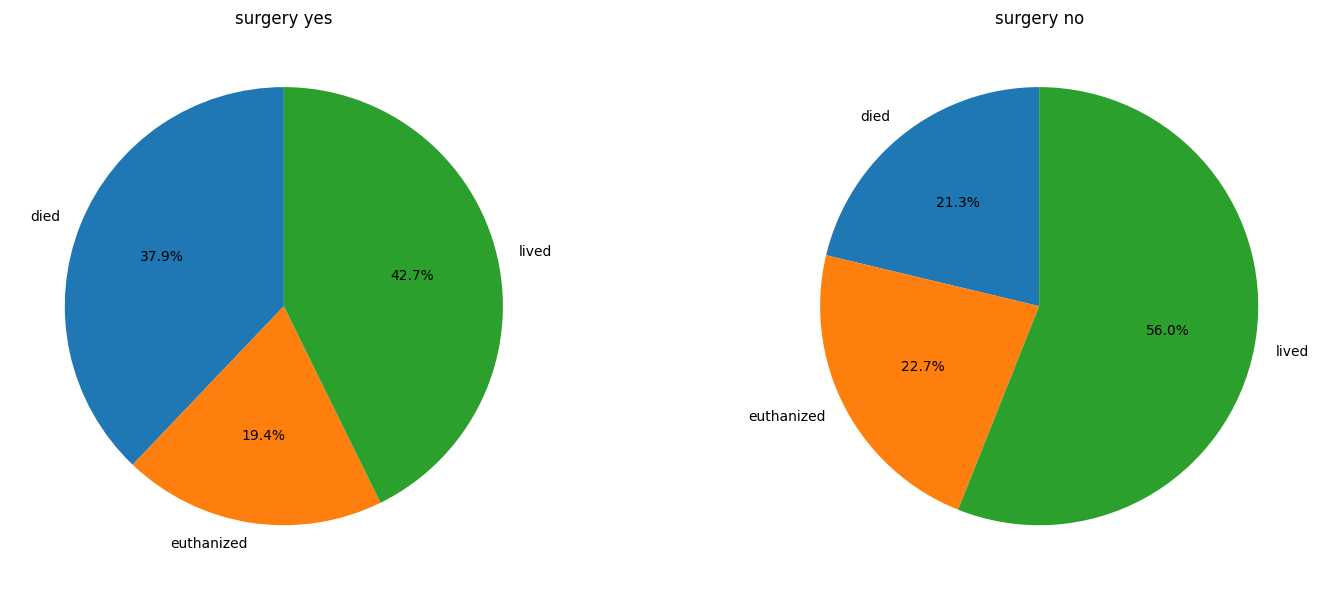

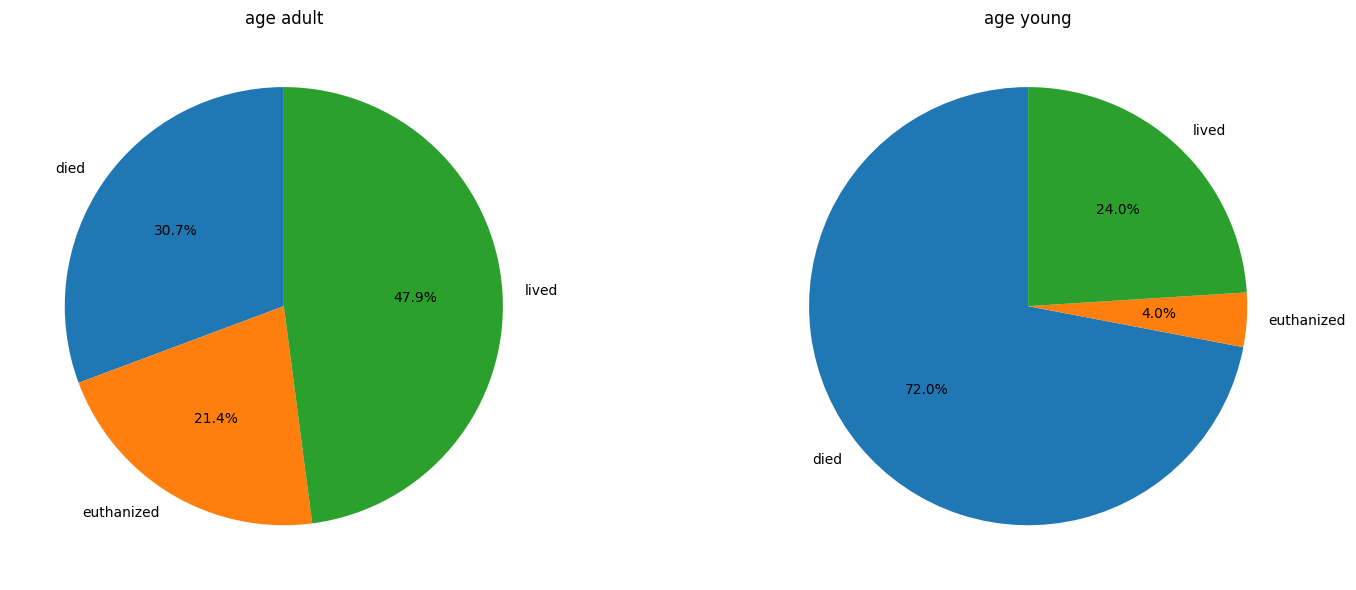

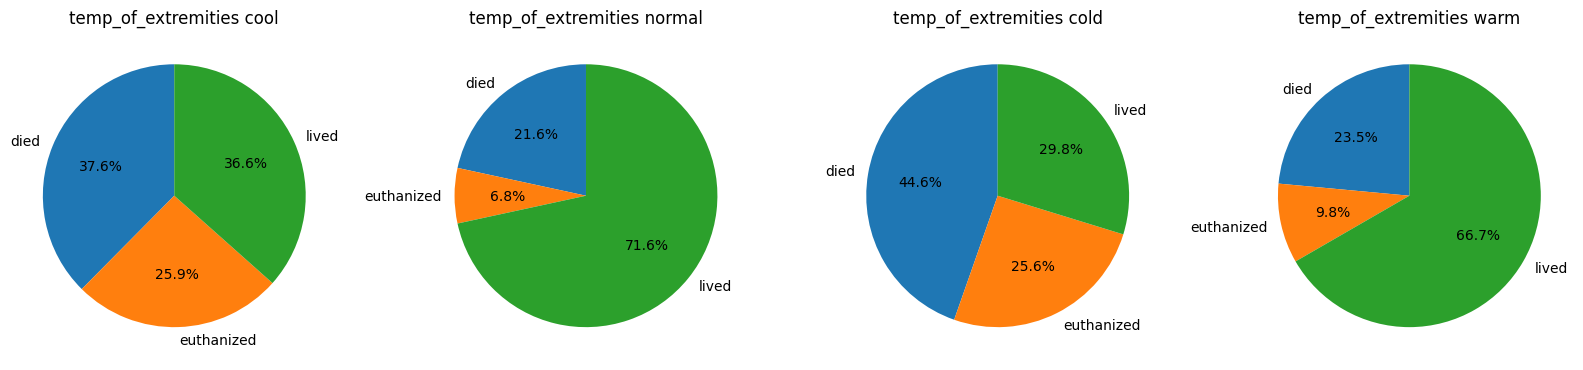

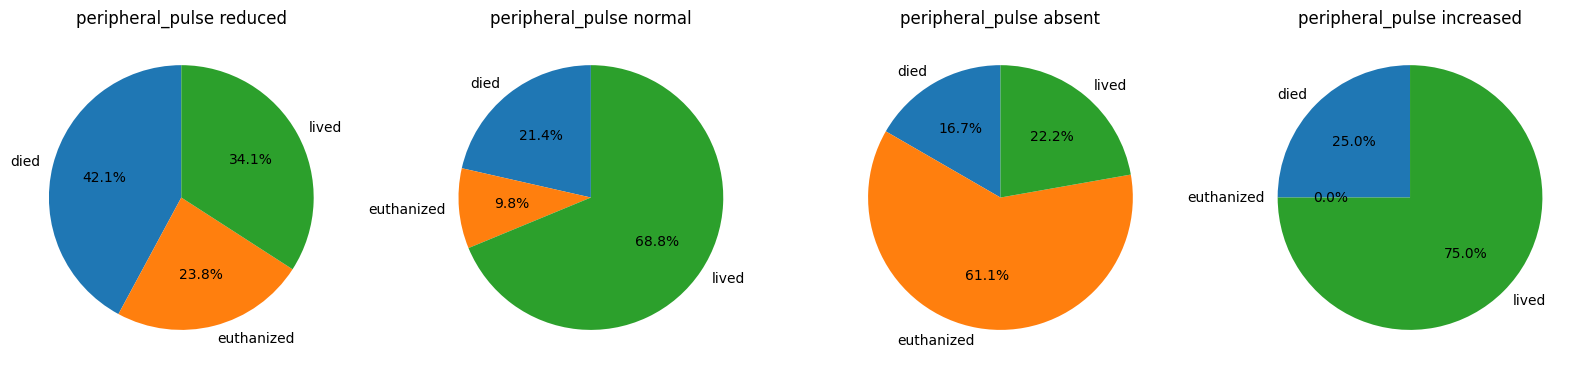

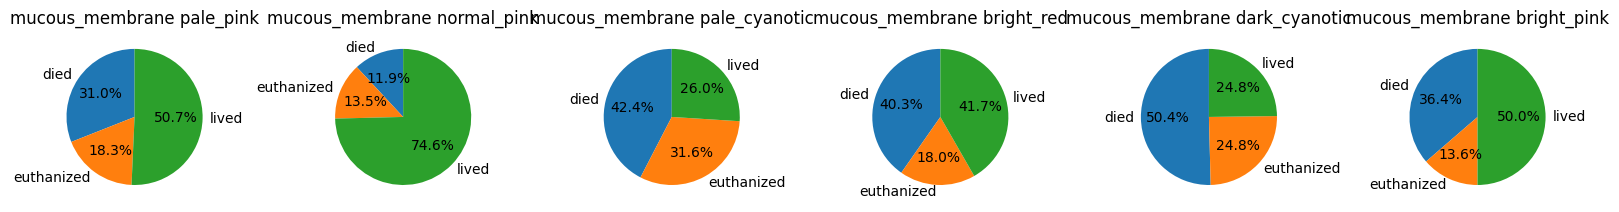

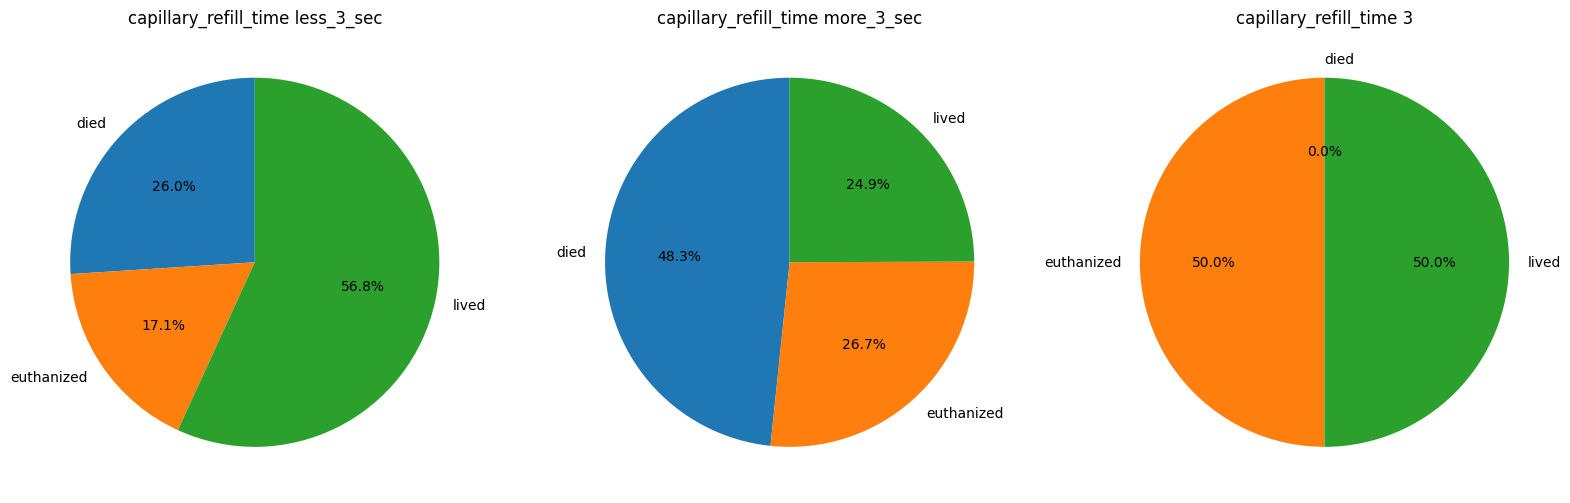

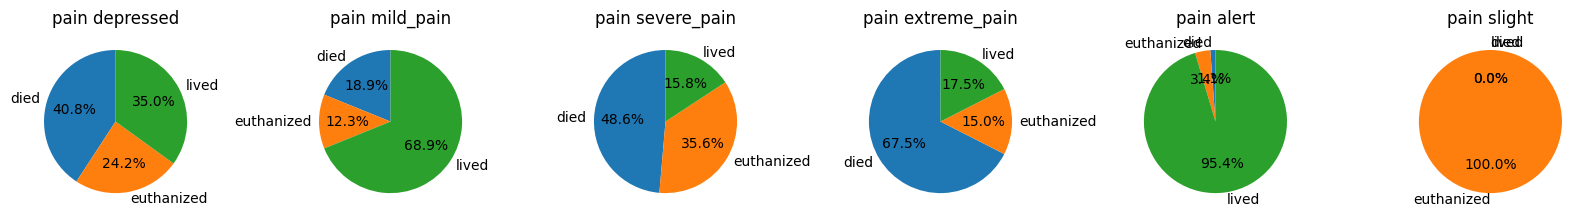

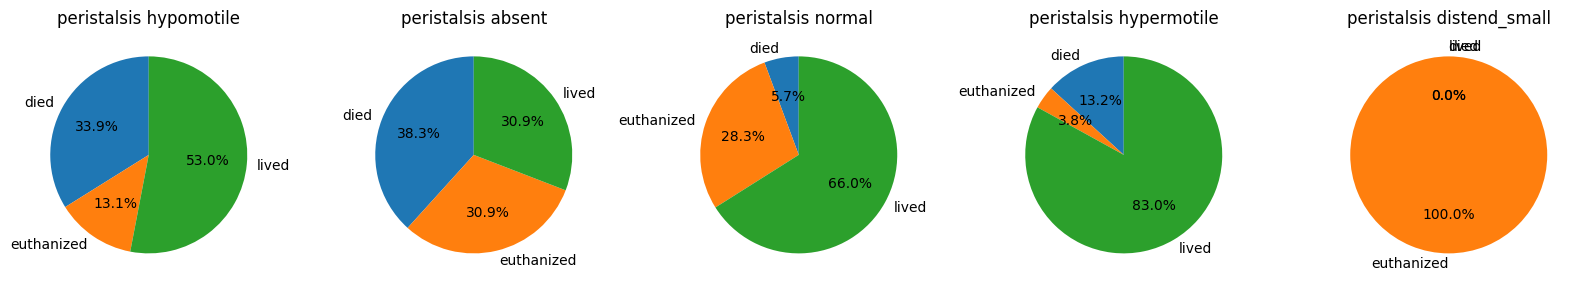

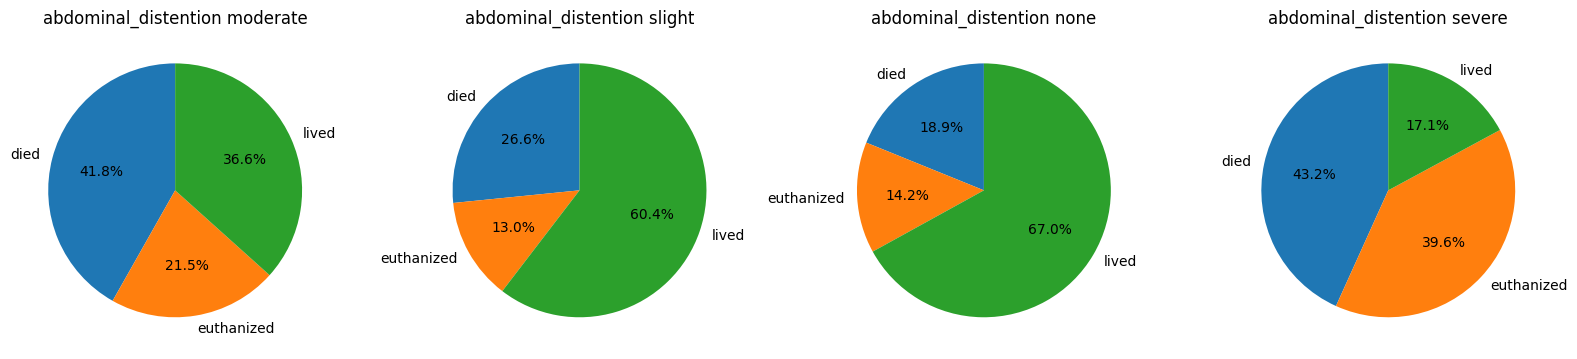

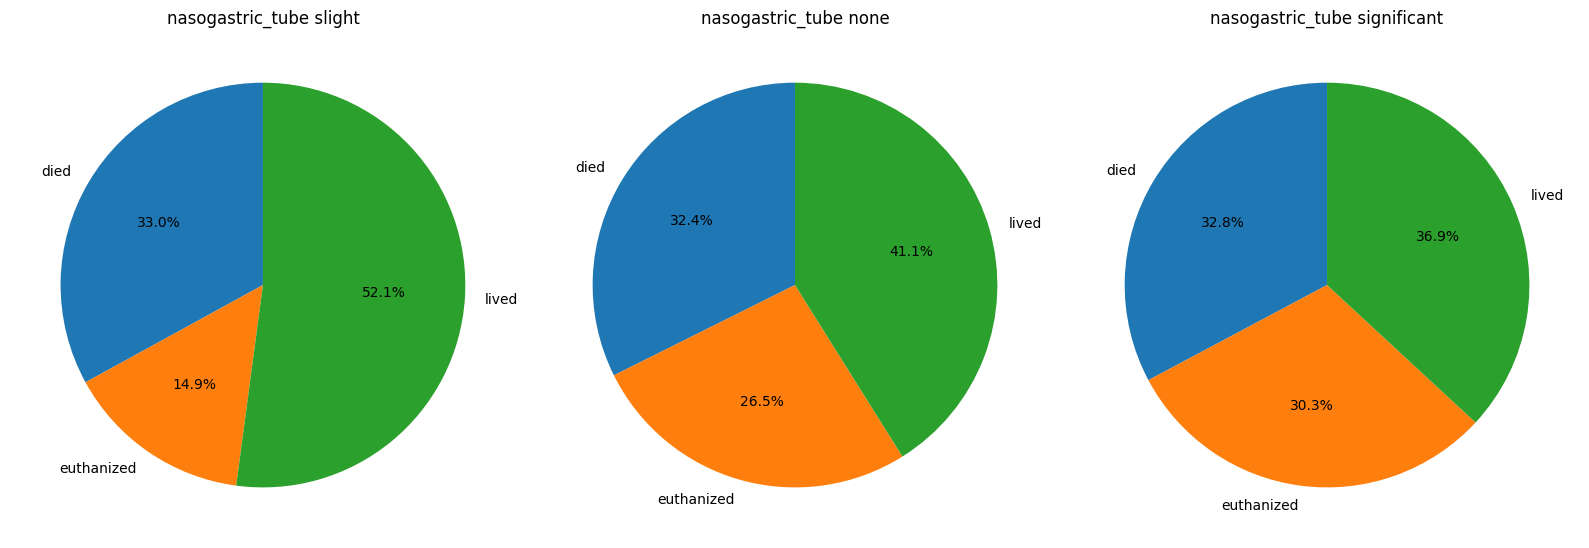

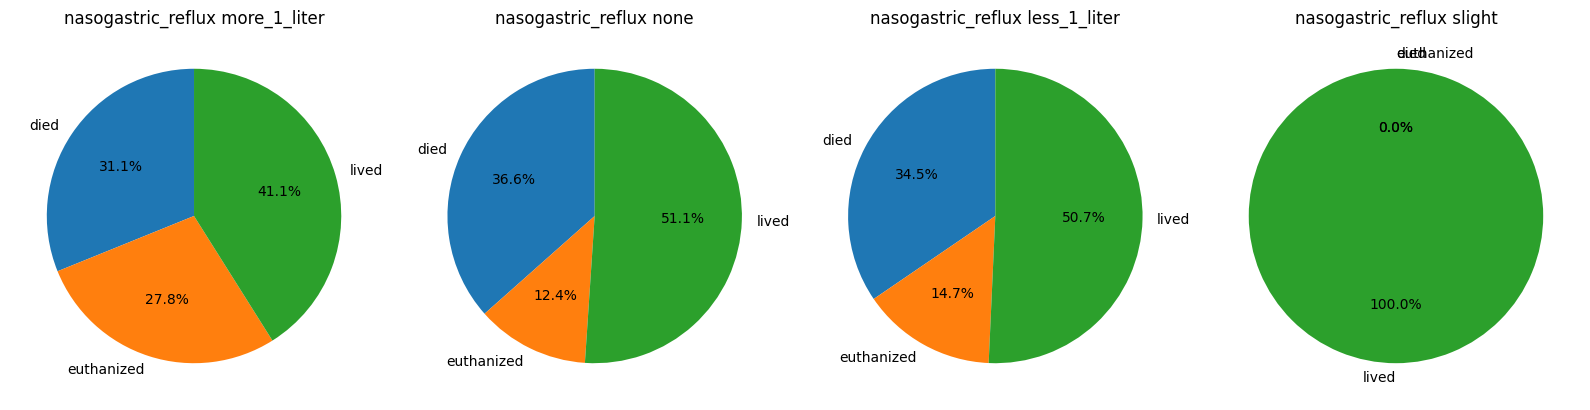

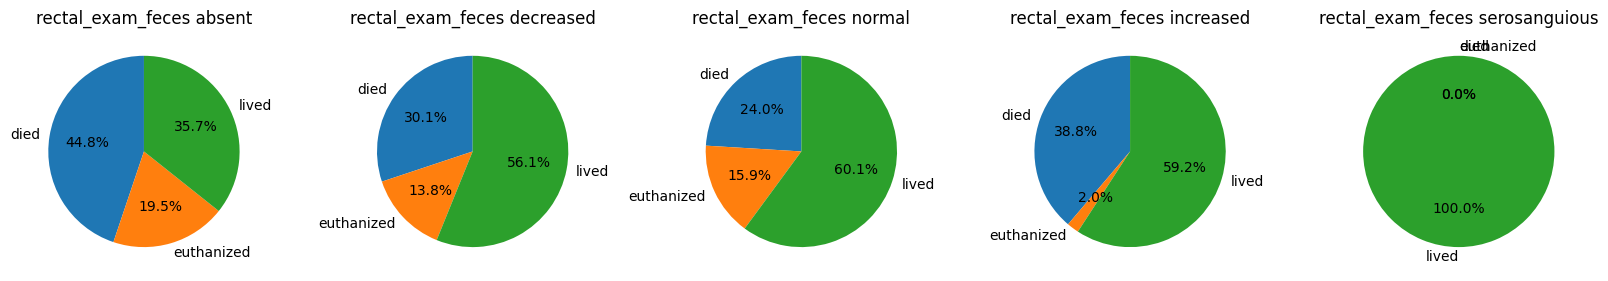

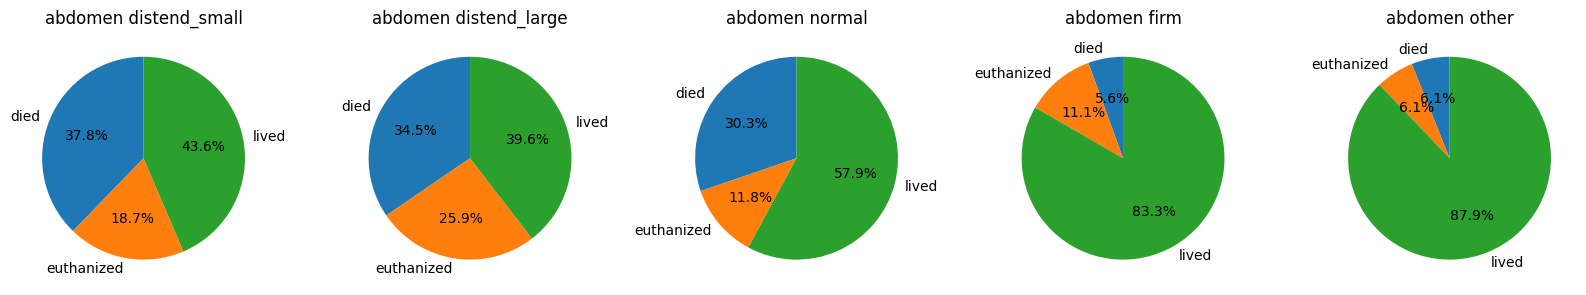

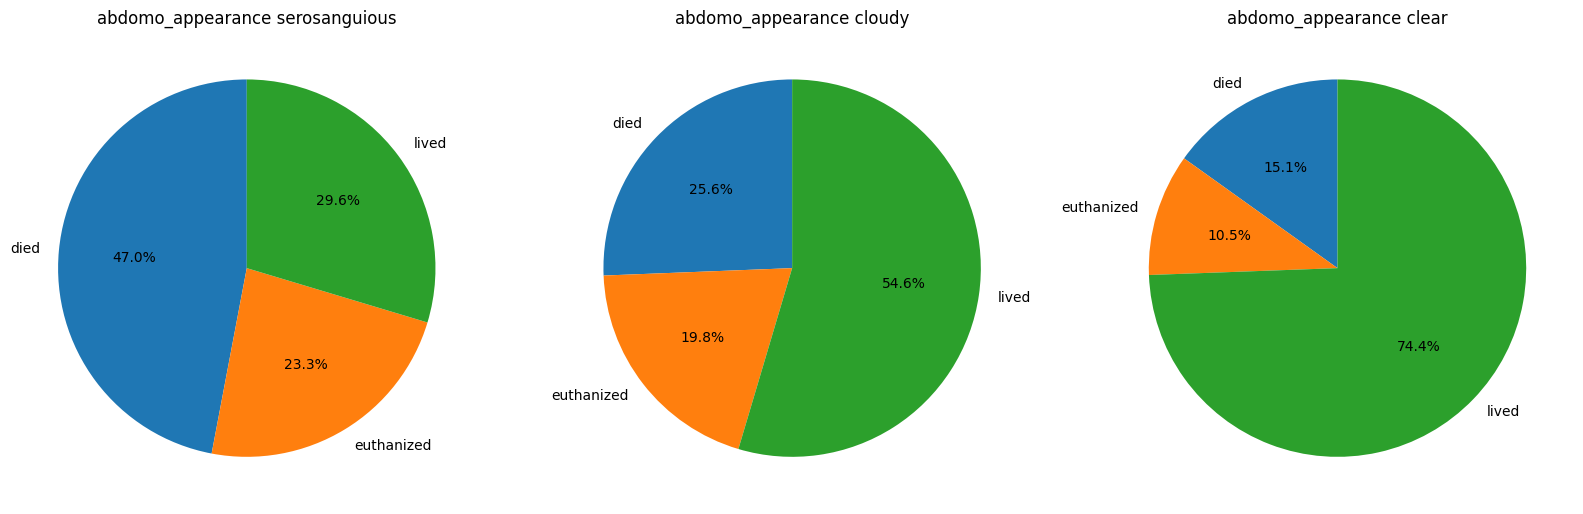

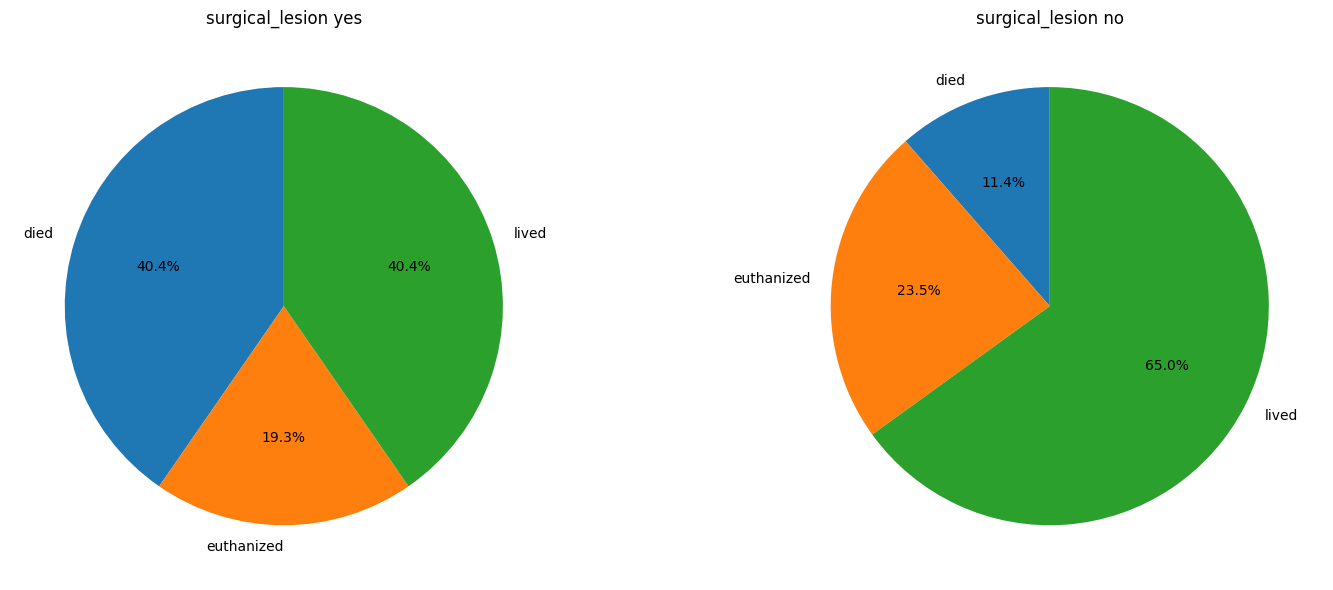

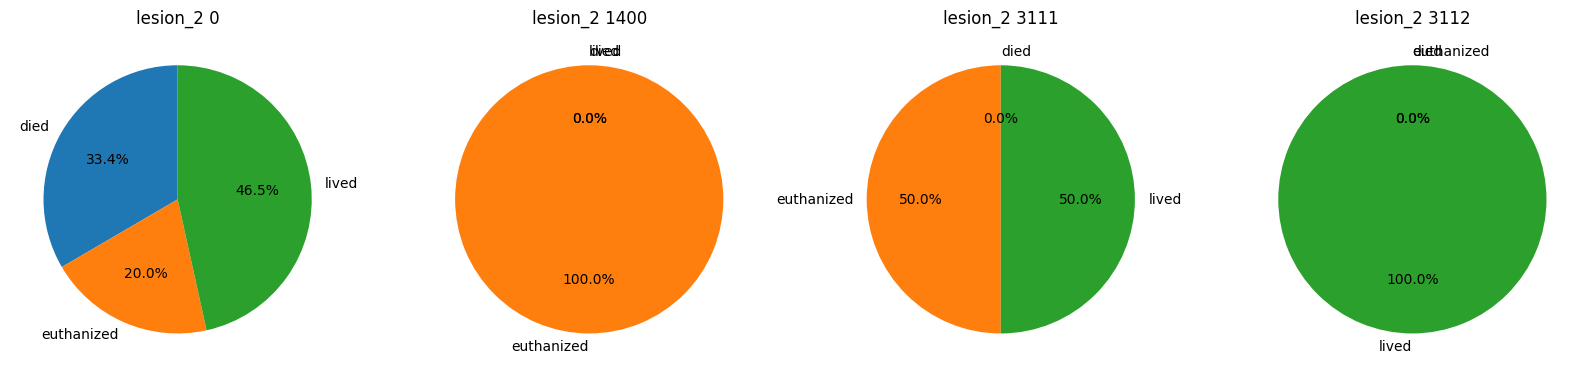

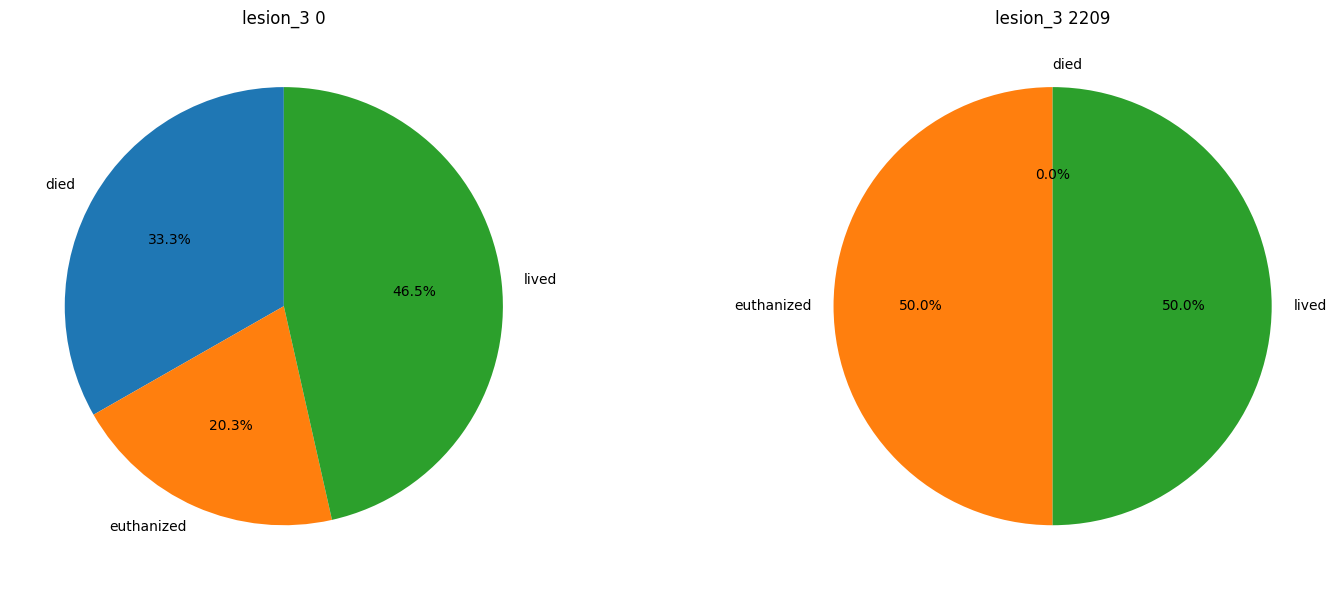

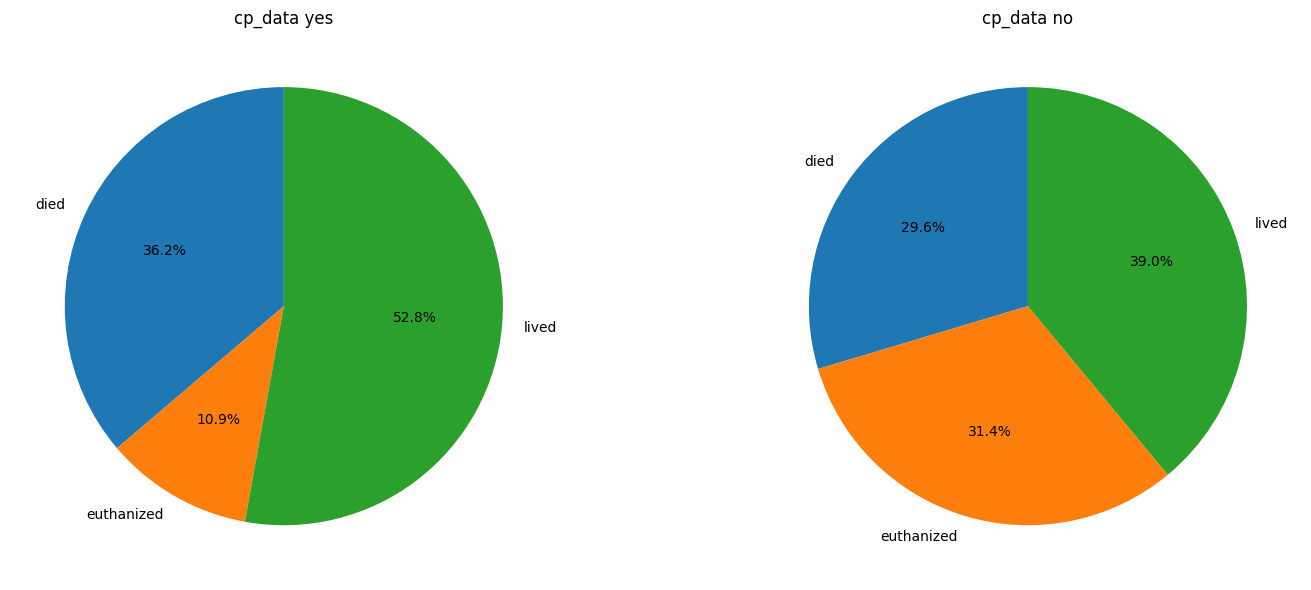

In [18]:
for col in categorical:
    plot_target_representation(df, col)

### Numerical Variable Analysis 📈

There are **255** unique values for the hospital, which is unfortunate given this is desirable to be seen as a categorical variable.
It may be worth seeing which hospitals pop up the most to see if the rest can be feature-engineered into an ```hospital_other``` category.

In [19]:
len(df['hospital_number'].value_counts().keys())

255

Unfortunately, there are only a few hospitals that have 10 or more data points to make sense of. This will complicate categorizing this variable.

In [20]:
x = df['hospital_number'].value_counts().values
x.sort()
x

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  9,  9,
        9,  9,  9, 10, 10

In [21]:
if 'hospital_number' in df_clean.columns: df_clean = df_clean.drop('hospital_number', axis=1)